In [18]:
import numpy as np
import tensorflow as tf
import time
import math

In [30]:
voxel_train = np.load('voxel_train.npy')
gt_train = np.load('gt_train.npy')

voxel_test = voxel_train[-1000:, :]
gt_test = gt_train[-1000:,:]
voxel_train = voxel_train[:-1000,:]
gt_train = gt_train[:-1000,:]

In [20]:
# Define the network structure
inputs = tf.keras.Input(shape=(6,)) #number of inputs
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(inputs)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
x = tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x)
outputs = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear, kernel_initializer='he_uniform',bias_initializer=tf.keras.initializers.Constant(0.01))(x) # no. of outputs
#outputs=tf.keras.layers.Dense(1, activation=tf.keras.activations.relu, kernel_initializer='normal',bias_initializer=tf.keras.initializers.Constant(0.1))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [21]:
# Define optimizer and train the network

# To save the model for each epoch, uncomment the checkpoint_callback below
# checkpoint_callback=tf.keras.callbacks.ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True mode='auto', save_freq='epoch')

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='mse', metrics='mse')

start=time.time()

history = model.fit(voxel_train, gt_train,epochs=10, batch_size=10, validation_split=0.1)  # starts training

# 2nd set of parameters
# model.fit(voxel_train, gt_train,epochs=100, batch_size=100, validation_data=(voxel_valid,gt_valid),callbacks=[checkpoint_callback])  # starts training

end=time.time()
print('Time Elapsed:%i seconds'%(end-start))

Epoch 1/10
89910/89910 [==============================] - 96s 1ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 9.5104e-05 - val_mse: 9.5104e-05
Epoch 2/10
89910/89910 [==============================] - 98s 1ms/step - loss: 1.9259e-04 - mse: 1.9259e-04 - val_loss: 1.2119e-04 - val_mse: 1.2119e-04
Epoch 3/10
89910/89910 [==============================] - 95s 1ms/step - loss: 1.4497e-04 - mse: 1.4497e-04 - val_loss: 7.6157e-05 - val_mse: 7.6157e-05
Epoch 4/10
89910/89910 [==============================] - 97s 1ms/step - loss: 1.2365e-04 - mse: 1.2365e-04 - val_loss: 7.4970e-05 - val_mse: 7.4970e-05
Epoch 5/10
89910/89910 [==============================] - 95s 1ms/step - loss: 1.2083e-04 - mse: 1.2083e-04 - val_loss: 7.9398e-05 - val_mse: 7.9398e-05
Epoch 6/10
89910/89910 [==============================] - 97s 1ms/step - loss: 1.1489e-04 - mse: 1.1489e-04 - val_loss: 8.2660e-05 - val_mse: 8.2660e-05
Epoch 7/10
89910/89910 [==============================] - 99s 1ms/step - loss: 1.1839e-04 

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


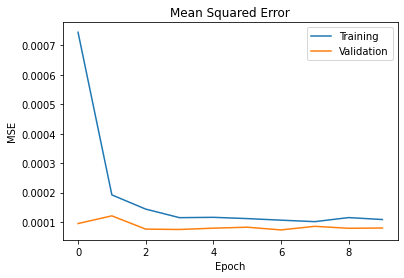

In [26]:
#print(model.summary())
print(history.history.keys())

import matplotlib.pyplot as plt
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [23]:
results = model.evaluate(voxel_test, gt_test, batch_size=10)
print("test loss, test mse:", results)

100/100 [==============================] - 0s 494us/step - loss: 7.8671e-05 - mse: 7.8671e-05
test loss, test mse: [7.867062231525779e-05, 7.867062231525779e-05]


In [24]:
voxel_test = voxel_test[0:10,:]
gt_predict = model.predict(voxel_test)
# show the inputs and predicted outputs
for i in range(len(voxel_test)):
	print("Actual T2=%s, Predicted=%s" % (gt_test[i], gt_predict[i]))

Actual T2=[1.99], Predicted=[1.9877625]
Actual T2=[0.1], Predicted=[0.09407087]
Actual T2=[0.1], Predicted=[0.09769931]
Actual T2=[0.1], Predicted=[0.09480459]
Actual T2=[0.08], Predicted=[0.08768229]
Actual T2=[0.08], Predicted=[0.08794954]
Actual T2=[1.99], Predicted=[1.9880785]
Actual T2=[0.08], Predicted=[0.09442846]
Actual T2=[0.1], Predicted=[0.08883055]
Actual T2=[1.99], Predicted=[1.990636]


In [27]:
model.save('voxel_regression')

INFO:tensorflow:Assets written to: voxel_regression\assets
